# Parte 2

![](https://www.digitalcitizen.life/wp-content/uploads/2020/01/google_play.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split

In [3]:
import sys
sys.path.append('lib')
from examinar import EDA
from normalizacion import NLP

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import nltk

In [6]:
from wordcloud import WordCloud, ImageColorGenerator
import multidict as multidict
from collections import Counter
import re

In [7]:
try:
    import joypy
except ImportError:
    !pip install joypy  # instala la librería
    import joypy

In [8]:
try:
    import joblib
except ImportError:
    !pip install joblib  # instala la librería
    import joblib

In [9]:
pd.set_option('display.max_colwidth', 1)

## Cargar datos y EDA

In [10]:
data = pd.read_csv('data/googleplaystore_user_reviews.csv').dropna()

In [11]:
print(f'\n***** El dataset coniene {data.shape[0]} registros y {data.shape[1]} atributos\n')
data.head(3)


***** El dataset coniene 37427 registros y 5 atributos



,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,"I like eat delicious food. That's I'm cooking food myself, case ""10 Best Foods"" helps lot, also ""Best Before (Shelf Life)""",Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000


In [12]:
data.rename(columns={'Translated_Review':'Reviews'}, inplace=True)

 ## Metadata

<ul>
<li>App: </li>
<li>Reviews: </li>
<li>Sentiment: </li>
<li>Sentiment_Polarity: </li>
<li>Sentiment_Subjectivity: </li>
<li>target: </li>
</ul>

## Completitud

In [13]:
eda = EDA(data)
eda.infoplus()

,columna,tipo,total,faltantes,pct,unico
0,App,object,37427,0,100.0,865
1,Reviews,object,37427,0,100.0,27994
2,Sentiment,object,37427,0,100.0,3
3,Sentiment_Polarity,float64,37427,0,100.0,5410
4,Sentiment_Subjectivity,float64,37427,0,100.0,4474


<div class="alert alert-block alert-info">
    <b>Completitud:</b> 
    <ul>
        <li>La tabla de completitud nos muestra que no hay informacion faltante.
        <li>Que la columna Target, que además es la variable objetivo, solo contiene 2 valores únicos.
        <li>La variable independiente es Text.
        <li>El valor positivo original, 4, se cambio para 1, por ser mas intiutivo.
        <li>Por último, se selecciono del dataset original 1.600.000 registros, solo una muestra.
    </ul>
</div>

## Duplicados

In [14]:
colrep = ['Sentiment','Reviews']
df = eda.duplicados(colrep)

***** El dataset original contiene 37427 registros y 5 atributos
Total de registros unicos: 27994
Total de registros duplicados: 9433
***** El dataset sin duplicados contiene 27994 registros y 5 atributos



<div class="alert alert-block alert-info">
    <b>Duplicados:</b> 
    <ul>
        <li>El dataset de muestra contenía duplicados que fueron eliminados.
    </ul>
</div>

In [15]:
df = df[colrep]

In [16]:
df['largo_pre'] = df['Reviews'].apply(lambda x : len(x))

In [17]:
# Se eliminaran registros cuyo contenido solo contenga 2 caracteres

if df[df['largo_pre'] < 3].shape[0] > 0:
    print(f'***** Se eliminaron',df[df['largo_pre'] < 3].shape[0],'registros')
    df.drop(df[df['largo_pre'] < 3].index, inplace=True)

***** Se eliminaron 29 registros


In [18]:
df.head()

,Sentiment,Reviews,largo_pre
0,Positive,"I like eat delicious food. That's I'm cooking food myself, case ""10 Best Foods"" helps lot, also ""Best Before (Shelf Life)""",122
1,Positive,This help eating healthy exercise regular basis,47
3,Positive,Works great especially going grocery store,42
4,Positive,Best idea us,12
5,Positive,Best way,8


In [19]:
rev = EDA(df)
rev.infoplus()

,columna,tipo,total,faltantes,pct,unico
0,Sentiment,object,27965,0,100.0,3
1,Reviews,object,27965,0,100.0,27965
2,largo_pre,int64,27965,0,100.0,643


In [20]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
largo_pre,27965.0,113.084069,102.554253,3.0,37.0,86.0,159.0,2713.0


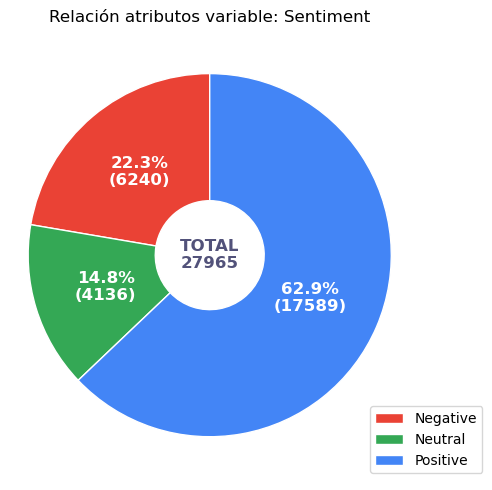

In [21]:
tgtcol = ['Sentiment']
rev.dona(tgtcol)

<div class="alert alert-block alert-warning">
    <b>Datos desbalanceados:</b> 
    <p>Se observa que la columna Sentiment, tiene tres atributos:
        <ul>
            <li>Negativo</li>
            <li>Neutral</li>
            <li>Positivo</li>
        </ul>
    También se ve que el dataset esta <strong>cargado</strong> hacia el atributo Positivo
</div>

In [22]:
df.drop(df[df['Sentiment']=='Neutral'].index,inplace=True)
df.loc[df['Sentiment'] == 'Positive', 'Sentiment'] = 1
df.loc[df['Sentiment'] == 'Negative', 'Sentiment'] = 0
df['Sentiment'] = df['Sentiment'].astype('int64')

In [23]:
rev = EDA(df)
rev.infoplus()

,columna,tipo,total,faltantes,pct,unico
0,Sentiment,int64,23829,0,100.0,2
1,Reviews,object,23829,0,100.0,23829
2,largo_pre,int64,23829,0,100.0,643


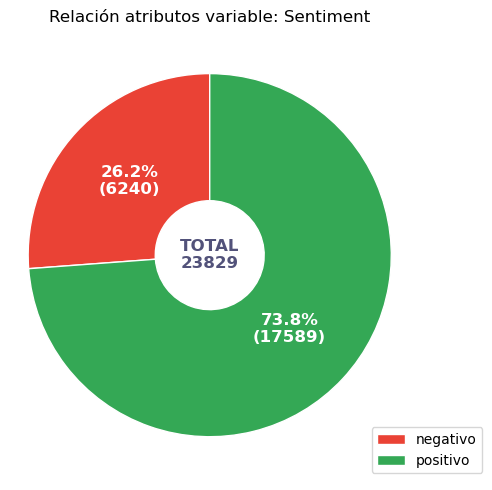

In [24]:
rev.dona(tgtcol, {1:'positivo',0:'negativo'})

<div class="alert alert-block alert-warning">
    <b>Datos objetivos:</b> 
    <p>Para este caso en particular, interesan solo los atributos:
        <ul>
            <li>Negativo</li>
            <li>Positivo</li>
        </ul>
    Con los cuales se procederá a realizar el EDA y el entrenamiento del modelo
</div>

# Normalización

In [26]:
txt = NLP()

<div class="alert alert-block alert-info">
    <b>Normalizacion o limpieza:</b> 
    <p>La siguiente función, realizara la normalización del dataset, tales como:
    <ul>
        <li>Cambiar todo el texto a minusculas
        <li>Expandir las contracciones de idioma inglés
        <li>Remover referencias a usuarios y hashtags
        <li>Eliminar etiquetas html y URLs
        <li>Remover los simbolos de puntuación
        <li>Quitar numeros
        <li>Remover caracteres solitarios, aquellos que tienen uno o dos solo caracteres
        <li>Quitar espacios
        <li>Eliminar palabras de parada, con la excepción de NO y NOT
    </ul>
</div>

In [27]:
def limpieza(sentencias, verbose = False):
    # Data original
    if verbose == True : print('*'*25,'Dataset antes de la limpieza','*'*25,'\n' )
    if verbose == True : print(sentencias.head(),'\n')
    #display(df['text'].head())
    
# Texto en minuscula
    sentencias = sentencias.apply(lambda x: x.lower())
    if verbose == True : print('*'*5,'minusculas:\n',sentencias.head(),'\n')
    
# Expandir 
    sentencias = sentencias.apply(lambda x : txt.expandir_contraccion(x))
    if verbose == True : print('*'*5,'expandir:\n',sentencias.head(),'\n')
    
# Remover referencias a usuarios como @switchfoot #charitytuesday
    pttrn = '(@|#)\w+'
    sentencias = sentencias.apply(lambda x: txt.quitar_patron(x, pttrn))
    if verbose == True : print('*'*5,'quitar usuarios:\n',sentencias.head(),'\n')
    
# Remover html
    pttrn = '<.*?>'
    sentencias = sentencias.apply(lambda x : txt.quitar_patron(x, pttrn))
    if verbose == True : print('*'*5,'quitar html:\n',sentencias.head(),'\n')
    
# Remover los URL de los tuits
    pttrn = r'https?://\S+|www\.\S+'
    sentencias = sentencias.apply(lambda x : txt.quitar_patron(x, pttrn))
    if verbose == True : print('*'*5,'quitar URL:\n',sentencias.head(),'\n')
    
# Remover basura
    pttrn = '&[\w]+;|lol|https?|_'
    sentencias = sentencias.apply(lambda x : txt.quitar_patron(x, pttrn))
    if verbose == True : print('*'*5,'quitar basura:\n',sentencias.head(),'\n')
        
# Remover signos de puntuación
    pttrn = '\W'
    sentencias = sentencias.apply(lambda x : txt.quitar_patron(x, pttrn))
    if verbose == True : print('*** quitar simbolos:\n',sentencias.head(),'\n')
    
# Remover números
    pttrn = '\d+'
    sentencias = sentencias.apply(lambda x : txt.quitar_patron(x, pttrn))
    if verbose == True : print('*'*5,'quitar numeros:\n',sentencias.head(),'\n')

# Remover caracteres solitarios
    for i in range(0,2):
        pttrn = '\s(\w{1,2})\s'
        sentencias = sentencias.apply(lambda x : txt.quitar_patron(x, pttrn))
    if verbose == True : print('*'*5,'quitar solitarios:\n',sentencias.head(),'\n')  
    
# Remover espacios
    sentencias = sentencias.apply(lambda x:txt.quitar_espacios(x))
    if verbose == True : print('*'*5,'quitar espacios:\n',sentencias.head(),'\n')

# Eliminar las palabras de parada
    excepstop = ['no','not'] #['no','not']
    addstop = [] #['im','dc','go','na','oh']
    sentencias = sentencias.apply(lambda x:txt.quitar_stopwords(x,excepstop,addstop))
    #if verbose == True : print('*'*5,'quitar stopwords:\n',sentencias.head(),'\n')
    
    if verbose == True : print('\n','*'*25,'Dataset luego de la limpieza','*'*25,'\n')
    if verbose == True : print(sentencias.head())
    #print(df['text'].tail())    
    
    return sentencias

In [28]:
%%time 
df['Reviews'] = limpieza(df['Reviews'],True) #True

************************* Dataset antes de la limpieza ************************* 

0    I like eat delicious food. That's I'm cooking food myself, case "10 Best Foods" helps lot, also "Best Before (Shelf Life)"
1    This help eating healthy exercise regular basis                                                                           
3    Works great especially going grocery store                                                                                
4    Best idea us                                                                                                              
5    Best way                                                                                                                  
Name: Reviews, dtype: object 

***** minusculas:
 0    i like eat delicious food. that's i'm cooking food myself, case "10 best foods" helps lot, also "best before (shelf life)"
1    this help eating healthy exercise regular basis                                               

In [29]:
df.head()

,Sentiment,Reviews,largo_pre
0,1,like eat delicious food cooking food case best foods helps lot also best shelf life,122
1,1,help eating healthy exercise regular basis,47
3,1,works great especially going grocery store,42
4,1,best idea us,12
5,1,best way,8


In [30]:
df['largo_post'] = df['Reviews'].apply(lambda x : len(x))

In [31]:
# Se eliminaran registros cuyo contenido solo contenga 2 caracteres

if df[df['largo_post'] < 3].shape[0] > 0:
    print('***** Se eliminaron',df[df['largo_post'] < 3].shape[0],'registros')
    df.drop(df[df['largo_post'] < 3].index, inplace=True)

***** Se eliminaron 23 registros


In [32]:
print(f'\n***** El dataset coniene {df.shape[0]} registros y {df.shape[1]} atributos\n')
df.head()


***** El dataset coniene 23806 registros y 4 atributos



,Sentiment,Reviews,largo_pre,largo_post
0,1,like eat delicious food cooking food case best foods helps lot also best shelf life,122,83
1,1,help eating healthy exercise regular basis,47,42
3,1,works great especially going grocery store,42,42
4,1,best idea us,12,12
5,1,best way,8,8


In [33]:
post = EDA(df[['Sentiment','Reviews','largo_pre','largo_post']])

In [34]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Sentiment,23806.0,0.737881,0.439796,0.0,0.0,1.0,1.0,1.0
largo_pre,23806.0,123.726792,105.734970,3.0,46.0,99.0,173.0,2713.0
largo_post,23806.0,105.594346,90.998370,3.0,39.0,84.0,148.0,2288.0


In [35]:
post.infoplus()

,columna,tipo,total,faltantes,pct,unico
0,Sentiment,int64,23806,0,100.0,2
1,Reviews,object,23806,0,100.0,23162
2,largo_pre,int64,23806,0,100.0,643
3,largo_post,int64,23806,0,100.0,570


## Separación datos en pos y neg

In [36]:
neg = df[df['Sentiment'] == 0]
print(neg.shape)
neg.head(3)

(6240, 4)


,Sentiment,Reviews,largo_pre,largo_post
32,0,no recipe book unable recipe book,34,33
43,0,waste time needs internet time ask calls information,57,52
68,0,faltu plz waste time,23,20


In [37]:
pos = df[df['Sentiment'] == 1]
print(pos.shape)
pos.head(3)

(17566, 4)


,Sentiment,Reviews,largo_pre,largo_post
0,1,like eat delicious food cooking food case best foods helps lot also best shelf life,122,83
1,1,help eating healthy exercise regular basis,47,42
3,1,works great especially going grocery store,42,42


In [38]:
def merge(texto):
    return " ".join(review for review in texto)

txtpos = merge(pos['Reviews'])
txtneg = merge(neg['Reviews'])

def getFrequencyDictForText(sentence):
    fullTermsDict = multidict.MultiDict()
    tmpDict = {}

    # making dict for counting frequencies
    for text in sentence.split(" "):
        if re.match("a|the|an|the|to|in|for|of|or|by|with|is|on|that|be|im|not", text):
            continue
        val = tmpDict.get(text, 0)
        tmpDict[text.lower()] = val + 1
    for key in tmpDict:
        fullTermsDict.add(key, tmpDict[key])
    #print(tmpDict)
    return fullTermsDict

def top_text(top,texto):
    comun = nltk.FreqDist(texto)
    return comun.most_common(top)

def listas(texto):
    for i in range(0,len(texto)):
        x=[]
        y=[]
        z=[]
        for j in range(0,len(texto[i])):
            x.append(texto[i][j][0])
            y.append(texto[i][j][1])
            z.append(j)
        wordx.append(x)
        freqx.append(y)
        posx.append(z)
        
def nube(text, mask, color):
    wc = WordCloud(
        background_color='white',
        mask=mask,
        #contour_width=1,
        #contour_color='steelblue',
        colormap=color,
        collocation_threshold=5)
    return wc.generate_from_frequencies(text)

In [39]:
print('len palabras positivas',len(txtpos.split()))
print('len palabras negativas',len(txtneg.split()))
print('total',len(txtpos.split())+len(txtneg.split()))

len palabras positivas 276295
len palabras negativas 106548
total 382843


In [40]:
wordpos = getFrequencyDictForText(txtpos)
wordneg = getFrequencyDictForText(txtneg)
    
top = 10
toppos = top_text(top, wordpos)
topneg = top_text(top, wordneg)

In [41]:
wordx=[]
freqx = []
posx = [] 
qwerty = ['positiva','negativas']
texto = [toppos,topneg] 
listas(texto)

In [42]:
cm = [plt.colormaps.get_cmap('Blues'),plt.colormaps.get_cmap('Reds')]
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
width = 1.0

## Top de palabras

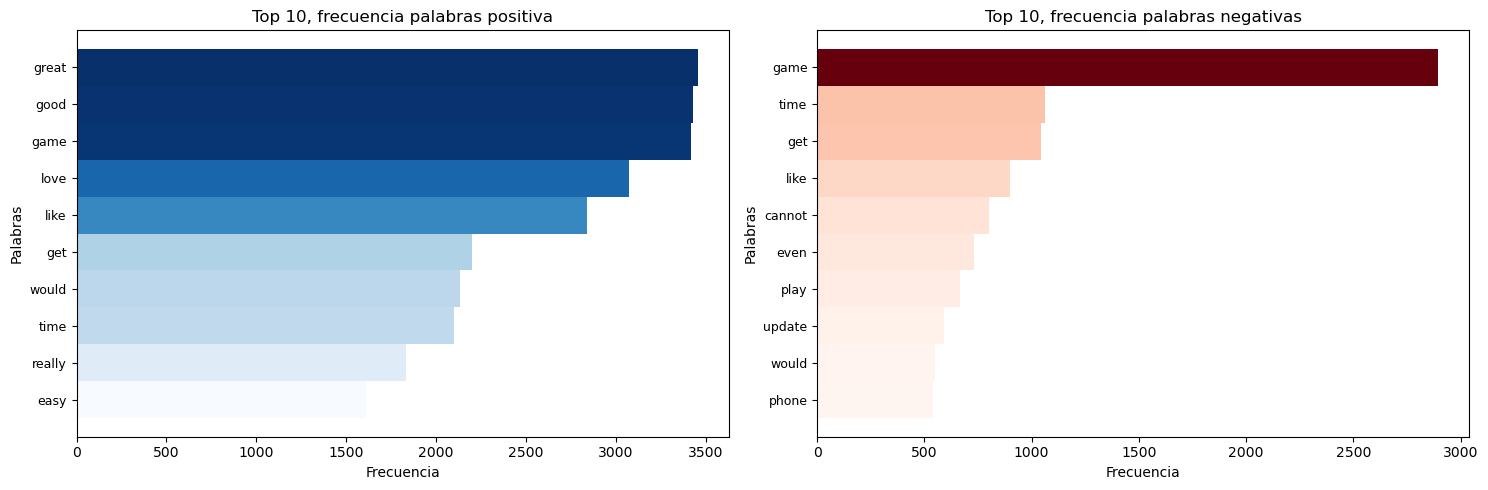

In [43]:
qty = 2
fig, ax = plt.subplots(1, qty,figsize=(15,5))
#ax = plt.axes(frameon=True)
for i in range(0, qty):
    ax[i].set_yticks(posx[i])
    ax[i].set_yticklabels(wordx[i], rotation='horizontal', fontsize=9) 
    ax[i].invert_yaxis() 
    ax[i].set_title('Top ' + str(top) + ', frecuencia palabras ' + qwerty[i]) 
    ax[i].barh(posx[i], freqx[i], width, color=cm[i](rescale(freqx[i]))) 
    ax[i].set_xlabel('Frecuencia')
    ax[i].set_ylabel('Palabras') 
    
plt.tight_layout()  
plt.show()

<div class="alert alert-block alert-warning">
    <b>Top de palabras:</b> 
    <ul>
        <li>Se puedes observar cual es el top de palabras más utilizadas según Sentiment, si son positivas en azul y negativas en rojo
    </ul>
</div>

In [45]:
maskp = np.array(Image.open('data/play.png'))
maskn = np.array(Image.open('data/play.png').transpose(Image.FLIP_LEFT_RIGHT)) #.transpose(Image.FLIP_LEFT_RIGHT)

In [46]:
colorpos = ImageColorGenerator(maskp)
colorneg = ImageColorGenerator(maskn)
poscloud = nube(wordpos,maskp,'Blues_r')
negcloud = nube(wordneg,maskn,'Greys_r')

## Nube de palabras

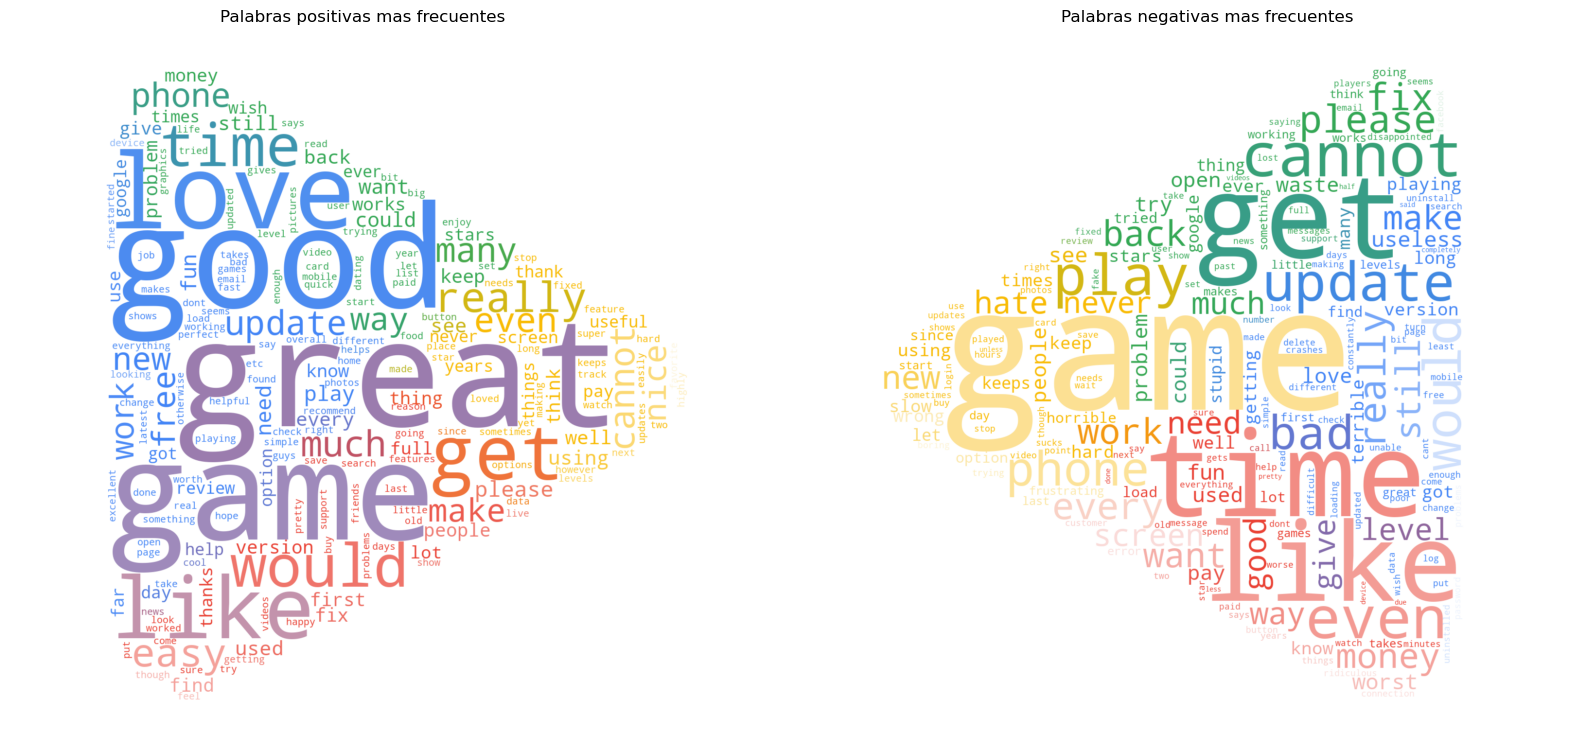

In [47]:
plt.figure(figsize=(20,20))

plt.subplot(1,2,1)
plt.imshow(poscloud.recolor(color_func=colorpos),interpolation='bilinear')  
plt.title('Palabras positivas mas frecuentes')
plt.axis("off")
 

plt.subplot(1,2,2)
plt.imshow(negcloud.recolor(color_func=colorneg),interpolation='bilinear')  #color_func=colorneg #random_state=123
plt.title('Palabras negativas mas frecuentes')
#plt.savefig('palabras_negativas',bbox_inches='tight')
plt.axis("off")

plt.show()

<div class="alert alert-block alert-info">
    <b>WordCloud:</b> 
    <ul>
        <li>La nube de palabras nos muestra las frecuencias de las palabras más utilizadas, tanto con sentido positivo, como negativo
    </ul>
</div>

# Actividad 3: Vectorización
Para entrenar el modelo de ML, el texto debe estar vectorizado, por ello, debes realizar la vectorización y justificar tus elecciones. Sin las justificaciones, se descontarán puntos.

In [48]:
idle, poss = train_test_split(pos, test_size=neg.shape[0], random_state=42)

In [49]:
result = pd.concat([neg,poss])

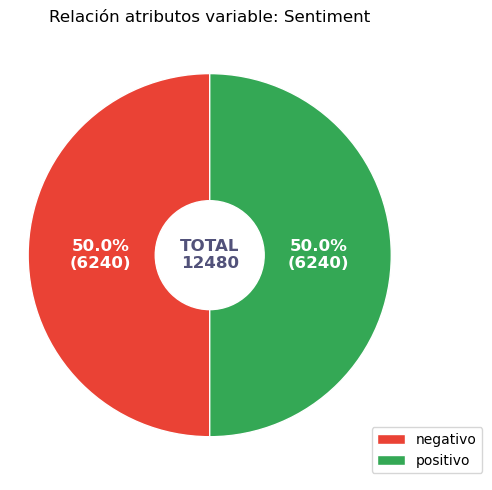

In [50]:
rev = EDA(result)
rev.dona(tgtcol, {1:'positivo',0:'negativo'})

<div class="alert alert-block alert-warning">
    <b>Datos balanceados:</b> 
<p>Se porocedio a tomar una muestra de los Sentimientos positivos, del mismo tamaño que los negativos. Para luego concatenar ambos dataframes en uno.
<p>Con este nuevo dataframe, resultado, se procedera a entrenar el modelo.

</div>

In [51]:
X = result['Reviews']
y = result['Sentiment']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.80, random_state=19)

In [55]:
type(X_train)

pandas.core.series.Series

In [56]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def vectorizar_txt(documents, feature_type='tfidf',ngram_range=(1, 1), min_df=0.0, max_df=1.0):

    feature_type = feature_type.lower().strip()  
    vectorizer = TfidfVectorizer(min_df=min_df, max_df=max_df,ngram_range=ngram_range)
    feature_matrix = vectorizer.fit_transform(documents).astype(float)
    
    return vectorizer, feature_matrix

## Vectorización TF-IDF

<div class="alert alert-block alert-info">
    <b>TF-IDF:</b> 
    <p>Se decidio usar TF-IDF, debido a:
    <ul>
        <li>Que permite conocer cuán relevante es un término en una colección de documentos dados.
        <li>Relevancia semántica.
        <li>Diferenciación de contenido.
        <li>Optimización precisa de palabras clave.
    </ul>
</div>

In [57]:
vectorizer, train_features = vectorizar_txt(documents=X_train,
                                                  feature_type='tfidf', 
                                                  ngram_range=(1, 1), 
                                                  min_df=0.0, 
                                                  max_df=1.0)

In [58]:
vectorizer

TfidfVectorizer(min_df=0.0)

# Funciones para calcular métricas

In [59]:
metricas = []
modelos = []
mediciones = ['Accuracy','Precision','Sensitivity(Recall)','F1 Score']

## Obtener métricas

In [60]:
from sklearn import metrics
def obtener_metricas(true_labels, predicted_labels):
    metrics_list = []
    metrics_dict = {'Accuracy':np.round(metrics.accuracy_score(true_labels,predicted_labels),4),
                    'Precision':np.round(metrics.precision_score(true_labels,predicted_labels,average='weighted'),4),
                    'Recall':np.round(metrics.recall_score(true_labels,predicted_labels,average='weighted'),4),
                    #'Specifity':np.round(metrics.recall_score(true_labels,predicted_labels,average='weighted',pos_label=0),4),
                    'F1 Score':np.round(metrics.f1_score(true_labels,predicted_labels,average='weighted'),4)}
    for item in metrics_dict:
        print(item,':',metrics_dict[item])
        metrics_list.append(metrics_dict[item])
    return metrics_list

## Matriz de confusión

In [61]:
def confusion_matrix(true_labels, predicted_labels, lbl_dicc=[]):
    classes = []
    lblclas = []
    for item in lbl_dicc.items():
        classes.append(item[0]),
        lblclas.append(item[1])

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels,labels=classes)
    print(cm,'\n') 
    
    fig, ax = plt.subplots()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Creación del mapa de calor
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="coolwarm_r" ,fmt='d', #'PiYG'
               xticklabels=lblclas,
               yticklabels=lblclas)
    ax.xaxis.set_label_position("top")
    plt.tight_layout()

    plt.title('Matriz de Confusión', y=1.1)
    plt.ylabel('Etiqueta real')
    plt.xlabel('Etiquieta prediccion')
    plt.savefig('img/matriz_confusion',bbox_inches='tight')
    plt.show()    

## Porcentajes métricas

In [62]:
gcolor = ['#ea4235','#34a855','#4385f6','#f9bb04','black']
def porcentajes(data,titulo):
    #colores =['#ee2f5a','#0098db','#a53692','#51a8b1']#['#1f77b4','#fb7f0f',]
    fig, ax = plt.subplots(1, len(data),figsize=(len(data)*4,4)) 
    for i in range(0,len(data)):
        #pct = []
        if len(data) == 1:
            pct = [data[i],100-data[i]]
            ax.set_title(titulo[i])
            ax.pie(pct,
                   radius=1,
                   colors = [gcolor[i],'lightgrey'], #b5b5b5:gris #d2d3d5:gris #ffffff:blanco #141f35_gris
                   startangle = 90,
                   counterclock=False,
                   wedgeprops=dict(width=0.7, edgecolor='w')
                  )

            plt.text(0,0, f'{data[i]}%',
                            weight='bold', size=18, color='#52527a',
                             ha='center', va='center')
        else:
            pct = [data[i],100-data[i]]
            ax[i].set_title(titulo[i])
            ax[i].pie(pct,
                   radius=1,
                   colors = [gcolor[i],'lightgrey'], #b5b5b5
                   startangle = 0,
                   counterclock=True,
                   wedgeprops=dict(width=0.7, edgecolor='w')
                  )
            ax[i].text(0,0, f'{data[i]}%',
                            weight='bold', size=18, color='#52527a',
                             ha='center', va='center')
            ax[i].axis('equal')
    #plt.tight_layout() 
    plt.show()

# Entrenamiento modelo
La seleccón del modelo fue, Máquinas de Vector Soporte, ya que no había utilizado este modelo anteriormente 

## SVM (Máquinas de Vector Soporte)

In [63]:
from sklearn.svm import SVC
svc = SVC(kernel='linear',gamma='auto')
svc.fit(train_features, y_train)
modelos.append('svc')

In [64]:
import joblib
joblib.dump(svc, 'svc.pkl')

['svc.pkl']

In [65]:
svc

SVC(gamma='auto', kernel='linear')

In [66]:
test_features_svc = vectorizer.transform(X_test)

In [67]:
predicted_sentiments_svc = svc.predict(test_features_svc)

### Métricas

In [68]:
metricas.append(obtener_metricas(true_labels=y_test, 
            predicted_labels=predicted_sentiments_svc))

Accuracy : 0.8878
Precision : 0.8886
Recall : 0.8878
F1 Score : 0.8877


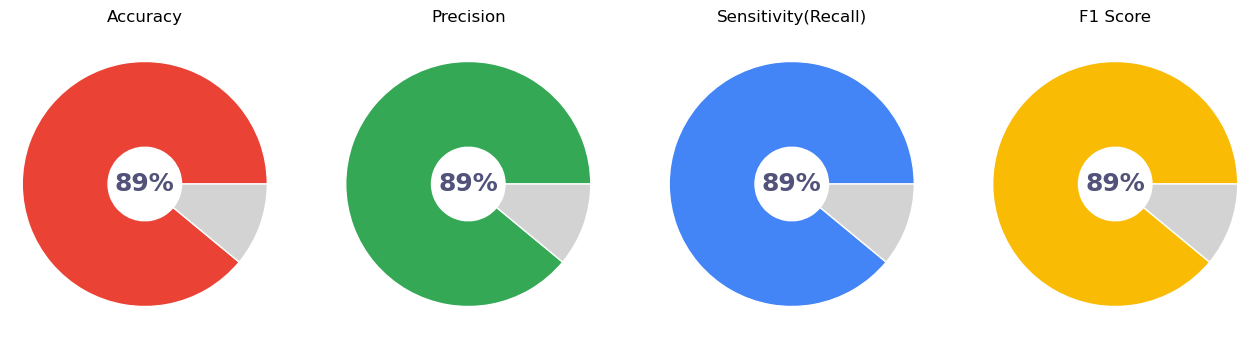

In [69]:
dat = metricas[0]
dat = list(map(lambda x:int(round(100*x,0)), dat))
porcentajes(dat,mediciones)

<div class="alert alert-block alert-warning">
    <b>Metricas:</b> 
<p>Podemos observar los resultados de las métricas más utilizadas
<br>No hay grandes difernecias entre ellas.
<br>Podríamos decir que el modelo tiene un 89% de efectividad.

</div>

### Matriz de confusión

[[1055  169]
 [ 111 1161]] 



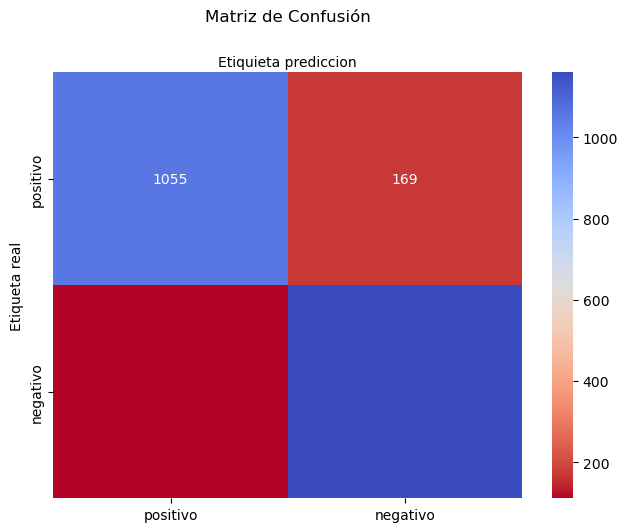

In [70]:
confusion_matrix(true_labels=y_test, 
                 predicted_labels=predicted_sentiments_svc,
                lbl_dicc = {1:'positivo',0:'negativo'})

---

## Reporte clasificación

In [71]:
print('Máquinas de Vector Soporte:\n',metrics.classification_report(predicted_sentiments_svc,y_test))

Máquinas de Vector Soporte:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89      1330
           1       0.86      0.90      0.88      1166

    accuracy                           0.89      2496
   macro avg       0.89      0.89      0.89      2496
weighted avg       0.89      0.89      0.89      2496



---

# Pruebas
A continuación se muestran algunas sugerencias de texto, que no fueron utilizadas en el entrenamiento del modelo

In [73]:
muestra,_ = train_test_split(idle, train_size=10, stratify=idle['Sentiment'])
muestra[['Reviews','Sentiment']]

,Reviews,Sentiment
31091,really like good,1
12765,excellent job,1
21552,great tracking everything home page keeps motivated lot nutrition info database incorrect manually input lot nutrition facts,1
33917,using several months really like design want express feelings get want anyone looking private life want hide diary,1
6052,loved awesomeness using allrecipes past years failed good thing recipes easy direct follow also helpful thinking make dinner regret try save recipes google home print cannot give stars kudos team members allrecipes made cooking easy fun,1
16303,happy cardiologist,1
37023,join dreamtrips best,1
12822,helping stay consistent taking medicine drinking water,1
46131,enjoyed using cruise holiday great ship spotting med biscay,1
58558,wow really good,1


---

In [74]:
texxto = input('Ingrese un texto: \n')

Ingrese un texto: 
 great app problem new updates working correctly rally app not syncing correctly


In [75]:
prueba = {'Reviews':texxto}
dfp = pd.DataFrame.from_dict([prueba])
dfp = limpieza(dfp['Reviews'])
test_features = vectorizer.transform(dfp)
predicted_sentiments = svc.predict(test_features)

In [76]:
enunciado = 'El texto ingresado es:'
if predicted_sentiments[0] == 0:
    print(enunciado,'\033[1m Negativo \033[1m')
else:
    print(enunciado,'\033[1m Positivo \033[1m')

El texto ingresado es:  Positivo 


---

## Prueba del modelo desde archivo

In [77]:
import json

with open('result.json', 'w') as fp:
    json.dump(prueba, fp)

In [78]:
def predict():
    json_ = json.load(open('result.json'))
    query_df = pd.DataFrame(json_, index=[0])
    dfp = limpieza(query_df['Reviews'])
    test_features = vectorizer.transform(dfp)
    
    classifier = joblib.load('svc.pkl')
    prediction = classifier.predict(test_features)
    print(prediction[0])
    if prediction[0] :
        return "TRUE: la 'Review' es positiva'"
    else :
        return "FALSE: la 'Review' es negativa"

In [79]:
predict()

1


"TRUE: la 'Review' es positiva'"